# Model Training Notebook: Warrior Pose Classification

## Introduction

This Jupyter Notebook is dedicated to training a machine learning model for the classification of the "Warrior Pose." The Warrior Pose, a fundamental yoga posture, demands a combination of balance, strength, and body alignment. In this project, we leverage BlazePose to gather body landmarks data and employ it for the classification of correct and incorrect execution of the Warrior Pose.

### Background

- The Warrior Pose is a well-known yoga asana that emphasizes strength, balance, and proper body positioning.
- Achieving a precise Warrior Pose involves the alignment of essential body landmarks.
- BlazePose, a pose estimation model, provides detailed body landmark information.

### Objectives

The primary goals of this undertaking are outlined as follows:

1. Acquire and preprocess body landmarks data through BlazePose for individuals performing the Warrior Pose.
2. Develop a machine learning model designed to discern whether the Warrior Pose is executed accurately or not.
3. Assess the model's performance using validation and test datasets.
4. Generate visualizations and analyze the model's outcomes.

### Dataset

We have assembled a dataset of body landmarks obtained via BlazePose. Each data point encompasses the spatial coordinates of key body landmarks during the Warrior Pose. This dataset is utilized for training, validation, and testing.

### Machine Learning Model

The machine learning model applied for classification is a neural network with a specific architectural configuration. We will delve into the model's structure, training regimen, and performance evaluation metrics throughout this notebook.

### Note

Prior to executing this notebook, please ensure that you have the required dependencies, the dataset, and the BlazePose implementation ready.

In [1]:
# Import Libraries

# Data Manipulation and Preprocessing
import numpy as np
import pandas as pd
import csv
import splitfolders

# Machine Learning
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

# Visualization
from matplotlib import pyplot as plt

# Miscellaneous
import os
import sys

# Download model from TF Hub and check out inference code from GitHub
!wget -q -O movenet_thunder.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/thunder/tflite/float16/4?lite-format=tflite
!git clone https://github.com/tensorflow/examples.git
pose_sample_rpi_path = os.path.join(os.getcwd(), 'examples/lite/examples/pose_estimation/raspberry_pi')
sys.path.append(pose_sample_rpi_path)

import utils
from data import BodyPart

zsh:1: no matches found: https://tfhub.dev/google/lite-model/movenet/singlepose/thunder/tflite/float16/4?lite-format=tflite
fatal: destination path 'examples' already exists and is not an empty directory.


# Data Loading and Preprocessing for Pose Classification

## Data Source and Preprocessing

The CSV files used in this code were created by processing pose images with BlazePose to obtain pose landmarks.

- **Training and Testing Split:** The dataset has been divided into training and testing sets with an 80-20 split ratio.

### CSV Files and Processing Details

- **Training Data:** The CSV file located at `csvs_out_train_path` contains pose landmarks and labels for the training dataset.

- **Testing Data:** The CSV file located at `csvs_out_test_path` contains pose landmarks and labels for testing the model. Additionally, data from the `csvs_out_test_real` CSV file is available for further testing.

- **Real Test Data:** The `csvs_out_test_real` CSV file contains pose landmarks obtained from images of real individuals. These images were collected by the author of this project, ensuring that the test dataset includes real-world, diverse scenarios.

**Note:** The original images used to create the real test dataset are not included in the dataset directory due to privacy considerations.


This code loads and preprocesses the data for the subsequent training and evaluation of a pose classification model. The pose landmarks are used as input features, and class labels are used for training and testing.


In [2]:
csvs_out_train_path = '../Dataset/warrior_csv/warrior_train.csv'
csvs_out_test_path = '../Dataset/warrior_csv/warrior_test.csv'
csvs_out_test_real = '../Dataset/warrior_csv/warroir_test_real.csv'

def load_pose_landmarks(csv_path):
  """Loads a CSV created by MoveNetPreprocessor.
  
  Returns:
    X: Detected landmark coordinates and scores of shape (N, 17 * 3)
    y: Ground truth labels of shape (N, label_count)
    classes: The list of all class names found in the dataset
    dataframe: The CSV loaded as a Pandas dataframe features (X) and ground
      truth labels (y) to use later to train a pose classification model.
  """

  # Load the CSV file
  dataframe = pd.read_csv(csv_path)
  df_to_process = dataframe.copy()

  # Drop the file_name columns as you don't need it during training.
  df_to_process.drop(columns=['filename'], inplace=True)

  # Extract the list of class names
  classes = df_to_process.pop('class_name').unique()

  # Extract the labels
  y = df_to_process.pop('class_no')

  # Convert the input features and labels into the correct format for training.
  X = df_to_process.astype('float64')

  return X, y, classes, dataframe

# Load the train data
X, y, class_names, _ = load_pose_landmarks(csvs_out_train_path)

X_train = X
y_train = y

# Load the test data
X_test, y_test, _, df_test = load_pose_landmarks(csvs_out_test_path)

X_test_real, y_test_real, _3, df_test3 = load_pose_landmarks(csvs_out_test_real)


# Pose Landmarks Normalization

## Landmarks Normalization Process

In this section, the code focuses on normalizing the pose landmarks obtained from the images. The normalization process includes the following steps:

1. **Centering the Pose:** The pose landmarks are adjusted to ensure that the center of the pose becomes (0, 0) in the coordinate system. This step helps eliminate any translation-related variations in the pose data.

2. **Scaling to a Constant Pose Size:** The landmarks are scaled to a consistent pose size, ensuring that the pose landmarks are comparable across different samples. This step helps in achieving consistent features for the pose classification model.

3. **Embedding Transformation:** The normalized landmark coordinates are converted into a pose embedding, which is a flattened vector. This embedding serves as the input features for the pose classification model.

By applying these normalization techniques, the code prepares the pose landmarks for effective use in training and evaluating the pose classification model.

**Reference:** The normalization code is adapted from the TensorFlow Lite [Pose Classification Tutorial](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/lite/g3doc/tutorials/pose_classification.ipynb).

In [3]:
def get_center_point(landmarks, left_bodypart, right_bodypart):
  """Calculates the center point of the two given landmarks."""

  left = tf.gather(landmarks, left_bodypart.value, axis=1)
  right = tf.gather(landmarks, right_bodypart.value, axis=1)
  center = left * 0.5 + right * 0.5
  return center
  
def get_pose_size(landmarks, torso_size_multiplier=2.5):
  """Calculates pose size.

  It is the maximum of two values:
    * Torso size multiplied by `torso_size_multiplier`
    * Maximum distance from pose center to any pose landmark
  """
  # Hips center
  hips_center = get_center_point(landmarks, BodyPart.LEFT_HIP, 
                                 BodyPart.RIGHT_HIP)

  # Shoulders center
  shoulders_center = get_center_point(landmarks, BodyPart.LEFT_SHOULDER,
                                      BodyPart.RIGHT_SHOULDER)

  # Torso size as the minimum body size
  torso_size = tf.linalg.norm(shoulders_center - hips_center)

  # Pose center
  pose_center_new = get_center_point(landmarks, BodyPart.LEFT_HIP, 
                                     BodyPart.RIGHT_HIP)
  pose_center_new = tf.expand_dims(pose_center_new, axis=1)
  # Broadcast the pose center to the same size as the landmark vector to
  # perform substraction
  pose_center_new = tf.broadcast_to(pose_center_new,
                                    [tf.size(landmarks) // (13*2), 13, 2])

  # Dist to pose center
  d = tf.gather(landmarks - pose_center_new, 0, axis=0,
                name="dist_to_pose_center")
  # Max dist to pose center
  max_dist = tf.reduce_max(tf.linalg.norm(d, axis=0))

  # Normalize scale
  pose_size = tf.maximum(torso_size * torso_size_multiplier, max_dist)

  return pose_size


def normalize_pose_landmarks(landmarks):
  """Normalizes the landmarks translation by moving the pose center to (0,0) and
  scaling it to a constant pose size.
  """
  # Move landmarks so that the pose center becomes (0,0)
  pose_center = get_center_point(landmarks, BodyPart.LEFT_HIP, 
                                 BodyPart.RIGHT_HIP)
  pose_center = tf.expand_dims(pose_center, axis=1)
  # Broadcast the pose center to the same size as the landmark vector to perform
  # substraction
  pose_center = tf.broadcast_to(pose_center, 
                                [tf.size(landmarks) // (13*2), 13, 2])
  landmarks = landmarks - pose_center

  # Scale the landmarks to a constant pose size
  pose_size = get_pose_size(landmarks)
  landmarks /= pose_size

  return landmarks


def landmarks_to_embedding(landmarks_and_scores):
  """Converts the input landmarks into a pose embedding."""
  # Reshape the flat input into a matrix with shape=(17, 3)
  reshaped_inputs = keras.layers.Reshape((13, 3))(landmarks_and_scores)
  #print(reshaped_inputs[:, :, 2])
  #print(reshaped_inputs[:, :, :2]);

  # Normalize landmarks 2D
  landmarks = normalize_pose_landmarks(reshaped_inputs[:, :, :2])

  # Flatten the normalized landmark coordinates into a vector
  embedding = keras.layers.Flatten()(landmarks)

  return embedding

X_normalized = landmarks_to_embedding(X_train);

# Model Definition and Training

In this section, we define and train the pose classification model.

## Model Architecture

The architecture of the pose classification model is defined as follows:

- Input Layer: The model receives input features with a shape of (39), representing normalized pose landmarks.
- Embedding Layer: Converts the input pose landmarks into a suitable format for classification.

- Dense Layers: Two hidden layers are incorporated into the model:

  - Layer 1: A dense layer with 128 units and ReLU6 activation is employed to introduce non-linearity.
  - Dropout Layer: A dropout layer with a 0.5 dropout rate is applied to prevent overfitting.
  - Layer 2: A second dense layer with 64 units and ReLU6 activation continues to capture complex patterns within the data.
  - Dropout Layer: Another dropout layer with a 0.5 dropout rate is added for regularization.

- Output Layer: The final layer consists of a single neuron with a sigmoid activation function, making it suitable for binary classification tasks.

This updated architecture enhances the model's capacity to learn intricate patterns within the normalized pose landmarks and introduces dropout layers for regularization, reducing the risk of overfitting.


In [4]:
# Define the model
inputs = tf.keras.Input(shape=(39))
embedding = landmarks_to_embedding(inputs)

layer = keras.layers.Dense(128, activation=tf.nn.relu6)(embedding)
layer = keras.layers.Dropout(0.5)(layer)
layer = keras.layers.Dense(64, activation=tf.nn.relu6)(layer)
layer = keras.layers.Dropout(0.5)(layer)
outputs = Dense(1, activation="sigmoid")(layer)

model = keras.Model(inputs, outputs)

## Model Compilation

- Loss Function: Binary Cross-Entropy.
- Optimizer: Adam.
- Metrics: accuracy.

In [5]:
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer= tf.keras.optimizers.Adam(),
    metrics=['accuracy'],
)

## Model Training

- Trained on X_train and y_train for 100 epochs.

In [6]:
history = model.fit(X_train, y_train, batch_size=32, epochs=160, validation_split=0.2, shuffle=True);

Epoch 1/160


2023-11-04 14:43:06.175230: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


13/13 [==============================] - 1s 12ms/step - loss: 0.6797 - accuracy: 0.6045 - val_loss: 0.7829 - val_accuracy: 0.0000e+00
Epoch 2/160
13/13 [==============================] - 0s 2ms/step - loss: 0.6477 - accuracy: 0.6965 - val_loss: 0.9089 - val_accuracy: 0.0000e+00
Epoch 3/160
13/13 [==============================] - 0s 2ms/step - loss: 0.6143 - accuracy: 0.6965 - val_loss: 1.0672 - val_accuracy: 0.0000e+00
Epoch 4/160
13/13 [==============================] - 0s 2ms/step - loss: 0.6054 - accuracy: 0.6965 - val_loss: 1.1779 - val_accuracy: 0.0000e+00
Epoch 5/160
13/13 [==============================] - 0s 2ms/step - loss: 0.6050 - accuracy: 0.6965 - val_loss: 1.2022 - val_accuracy: 0.0000e+00
Epoch 6/160
13/13 [==============================] - 0s 2ms/step - loss: 0.5947 - accuracy: 0.6965 - val_loss: 1.1500 - val_accuracy: 0.0000e+00
Epoch 7/160
13/13 [==============================] - 0s 2ms/step - loss: 0.5931 - accuracy: 0.6965 - val_loss: 1.1333 - val_accuracy: 0.0000e

# Model Evaluation and Accuracy Calculation

In this section, we assess the model's performance and calculate its accuracy.

## Model Evaluation

The code evaluates the model's predictions on the training data. It uses the following steps:

- `tensor_prob`: Predicted probabilities for each instance in the training data.
- `tensor_pred`: Predicted binary labels based on a probability threshold (0.5).
- Comparing the predicted labels (`tensor_pred`) with the true labels (`y`) to assess the model's accuracy.

## Accuracy Calculation

The accuracy of the model is calculated as a percentage. It reflects the proportion of correct predictions out of the total number of instances in the training dataset.

The calculated accuracy is displayed as a percentage value.


In [7]:
tensor_prob = model.predict(X_test)
tensor_pred = []

for p in tensor_prob:
    if (p[0] > 0.5):
        tensor_pred.append(1)
    else:
        tensor_pred.append(0)


compare = (y_test == tensor_pred)

accuracy = np.mean(compare) * 100

print(f'Accuracy: {accuracy}')

8/8 [==============================] - 0s 553us/step
Accuracy: 96.95652173913044


## Training Progress: Accuracy

In this section, we visualize the model's training progress by plotting accuracy on both the training and validation datasets over epochs.


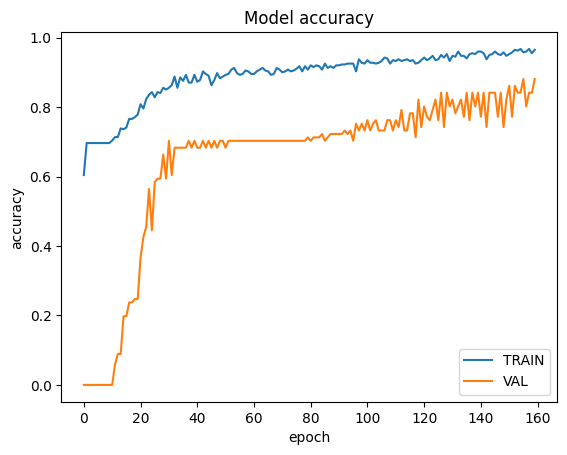

In [8]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['TRAIN', 'VAL'], loc='lower right')
plt.show()

# Model Evaluation with Confusion Matrix

In this section, we assess the performance of the pose classification model using a confusion matrix.

## Confusion Matrix

The code computes a confusion matrix, which is a valuable tool for visualizing the model's performance in a binary classification task. The matrix provides insights into the number of true positive, true negative, false positive, and false negative predictions. This is achieved through the following steps:

- `true_y`: True labels from the test data.
- `test_pred_decision_tree`: Predicted labels from the model.
- Using the `metrics.confusion_matrix` function to compute the confusion matrix.
- Displaying the confusion matrix using `ConfusionMatrixDisplay` with labels "Bad" and "Good."


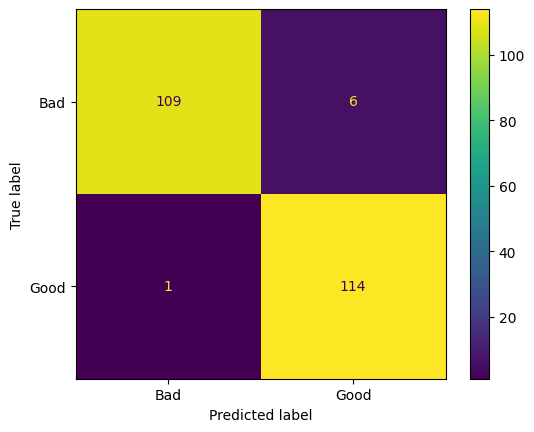

In [9]:
true_y = np.array(y_test);

confusion_matrix1 = confusion_matrix(true_y, tensor_pred)

cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix1, display_labels = ["Bad", "Good"])

cm_display.plot()
plt.show()

## Confusion Matrix and Accuracy for Real Images

In this section, we create a confusion matrix to evaluate the model's performance on real images.


1/1 [==============================] - 0s 11ms/step


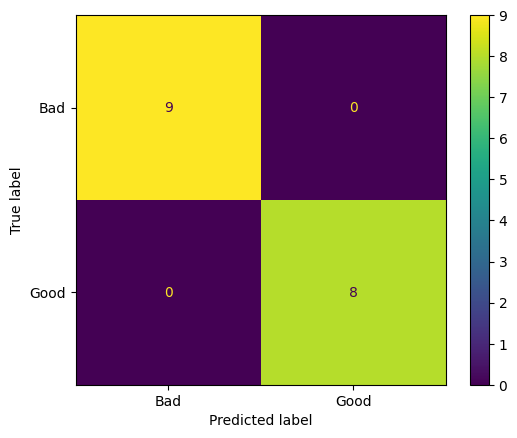

Accuracy on real Images 1.0


In [10]:
pred3 = model.predict(X_test_real)
test_pred_real = []
for p in pred3:
    if (p[0] > 0.4):
        test_pred_real.append(1)
    else:
        test_pred_real.append(0)

true_y3 = np.array(y_test_real);

confusion_matrix3 = confusion_matrix(true_y3, test_pred_real)

cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix3, display_labels = ["Bad", "Good"])

cm_display.plot()
plt.show()

print(f'Accuracy on real Images {accuracy_score(y_test_real, test_pred_real)}')

# Saving the Trained Model

In [11]:
model.save('../models/NN_warrior.tensorflow')

INFO:tensorflow:Assets written to: ../models/NN_warrior.tensorflow/assets


INFO:tensorflow:Assets written to: ../models/NN_warrior.tensorflow/assets


# Convert and Save TensorFlow Lite Model

In this section, we convert the trained pose classification model to TensorFlow Lite format for efficient deployment on various platforms. 

- The model is optimized for resource-constrained devices using `tf.lite.Optimize.DEFAULT`.
- It is saved as "NN_tree_testing.tflite" for deployment in edge devices and mobile applications.

This conversion enables versatile and efficient model deployment.


In [12]:
converter = tf.lite.TFLiteConverter.from_saved_model('../models/NN_warrior.tensorflow') # path to the SavedModel directory
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]
tflite_model = converter.convert()

# Save the model.
with open('../models/NN_warrior.tflite', 'wb') as f:
  f.write(tflite_model)

2023-11-04 14:43:13.592642: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2023-11-04 14:43:13.592660: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2023-11-04 14:43:13.593112: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: ../models/NN_warrior.tensorflow
2023-11-04 14:43:13.594916: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-11-04 14:43:13.594930: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: ../models/NN_warrior.tensorflow
2023-11-04 14:43:13.598432: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:357] MLIR V1 optimization pass is not enabled
2023-11-04 14:43:13.599728: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2023-11-04 14:43:13.630537: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at 